In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import anndata as ad
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import harmonypy as hm

import celltypist
from celltypist import models

import muon as mu
from muon import MuData

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Integrated_PTCL_CTCL_pcALCL_panfetal_raw.h5ad'
adata = sc.read_h5ad(input_file)

In [3]:
adata.X.expm1().sum(axis = 1)

matrix([[          inf],
        [1.1545434e+33],
        [          inf],
        ...,
        [          inf],
        [8.4383576e+26],
        [2.5813129e+20]], dtype=float32)

In [4]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:08): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:24:25)


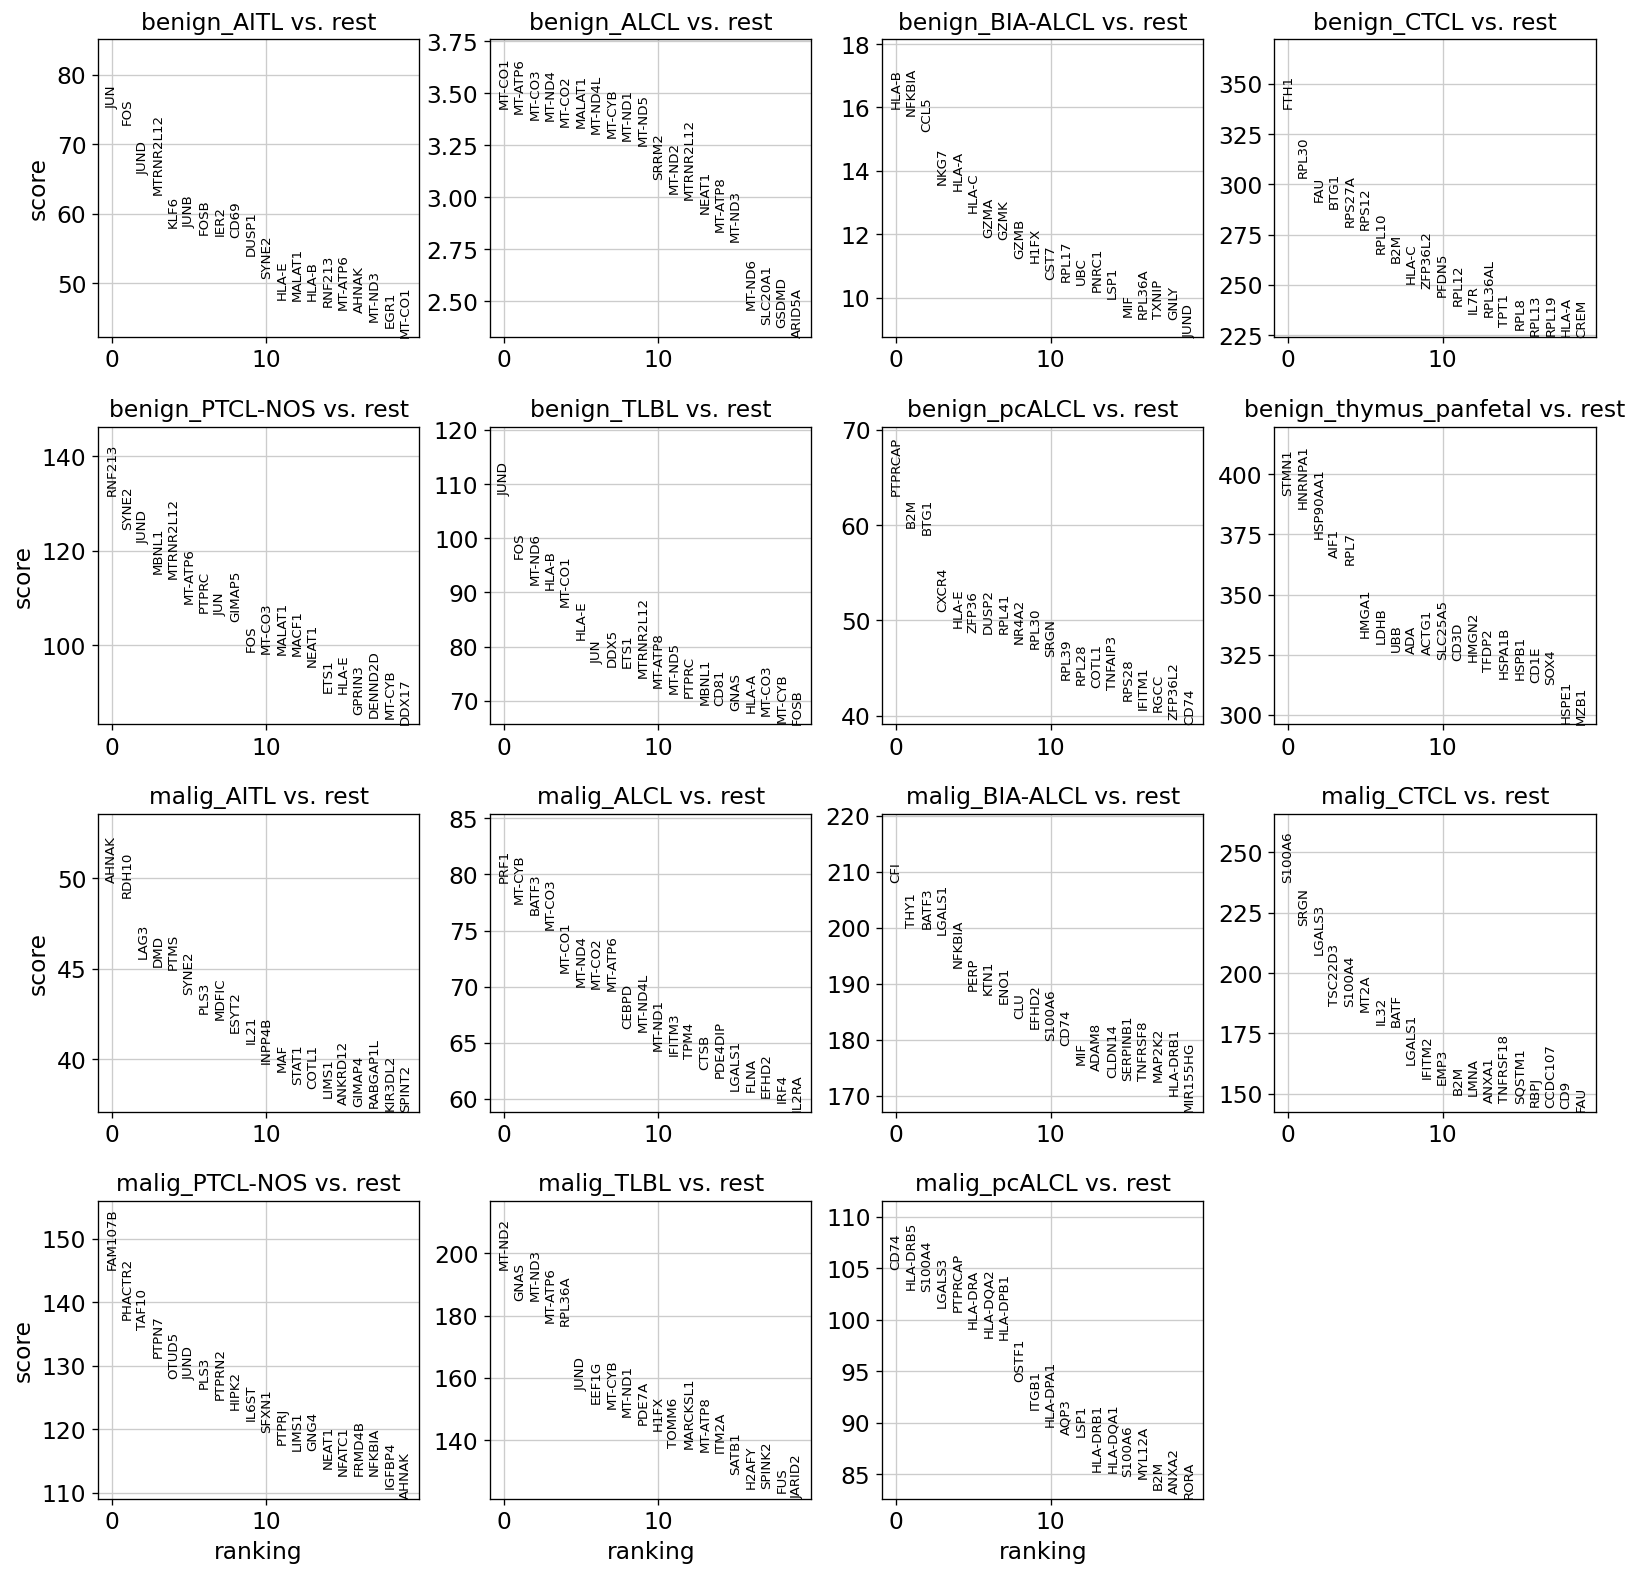

In [25]:
sc.tl.rank_genes_groups(adata, 'malignant_call2', method = 'wilcoxon', n_genes = 300)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

In [26]:
markers.to_csv('/home/jovyan/farm/T-cell_lym/malignant_markers/malignant_top300_DEGs_sc_with_panfetalT_skinT_CTCL_pcALCL_final.csv')

In [5]:
categories_order = ['benign_thymus_panfetal', 'benign_CTCL', 'benign_PTCL-NOS','benign_TLBL','benign_AITL','benign_ALCL','benign_BIA-ALCL','benign_pcALCL',
                    'malig_TL10712','malig_TL_MTK','malig_TL_Mangosteen','malig_TL_MAP006','malig_TL_KLT','malig_TL_SJH03','malig_pcALCL1','malig_pcALCL2',
                    'malig_TL5493','malig_TL6678','malig_TL6722',
                    'malig_TL4528','malig_TL8441','malig_TL3291','malig_TL5737','malig_TL5968','malig_TL5521','malig_TL2860',
                    'malig_CTCL1','malig_CTCL2','malig_CTCL3','malig_CTCL4','malig_CTCL5','malig_CTCL6','malig_CTCL7','malig_CTCL8']

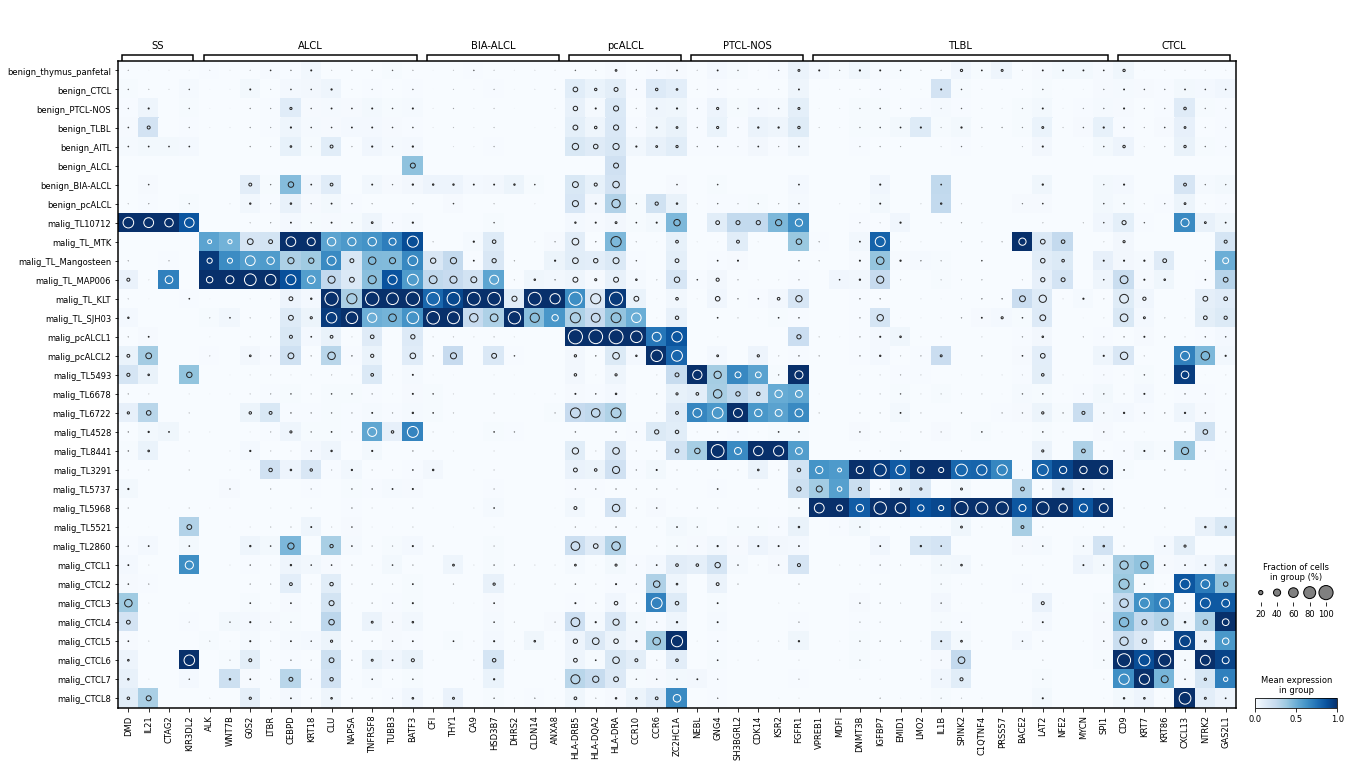

In [7]:
genes = {
    'SS': ['DMD','IL21','CTAG2','KIR3DL2'],
    'ALCL': ['ALK','WNT7B','G0S2','LTBR','CEBPD','KRT18','CLU','NAPSA','TNFRSF8','TUBB3','BATF3'],
    'BIA-ALCL':['CFI','THY1','CA9','HSD3B7','DHRS2','CLDN14','ANXA8'],
    'pcALCL':['HLA-DRB5','HLA-DQA2','HLA-DRA','CCR10','CCR6','ZC2HC1A'],
    'PTCL-NOS': ['NEBL','GNG4','SH3BGRL2','CDK14','KSR2','FGFR1'],
    'TLBL': ['VPREB1','MDFI','DNMT3B','IGFBP7','EMID1','LMO2','IL1B',
             'SPINK2','C1QTNF4','PRSS57','BACE2','LAT2','NFE2','MYCN','SPI1'],
    'CTCL':['CD9','KRT7','KRT86','CXCL13','NTRK2','GAS2L1']
}

dp = sc.pl.dotplot(adata, var_names=genes, groupby='malignant_call_donor',dendrogram=False,
                   var_group_rotation=0, swap_axes=False,standard_scale = 'var',
                   return_fig=True, categories_order = categories_order)
dp.style(cmap='Blues',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/T-cell_lym/script/figures/DEGs_integrated.pdf')

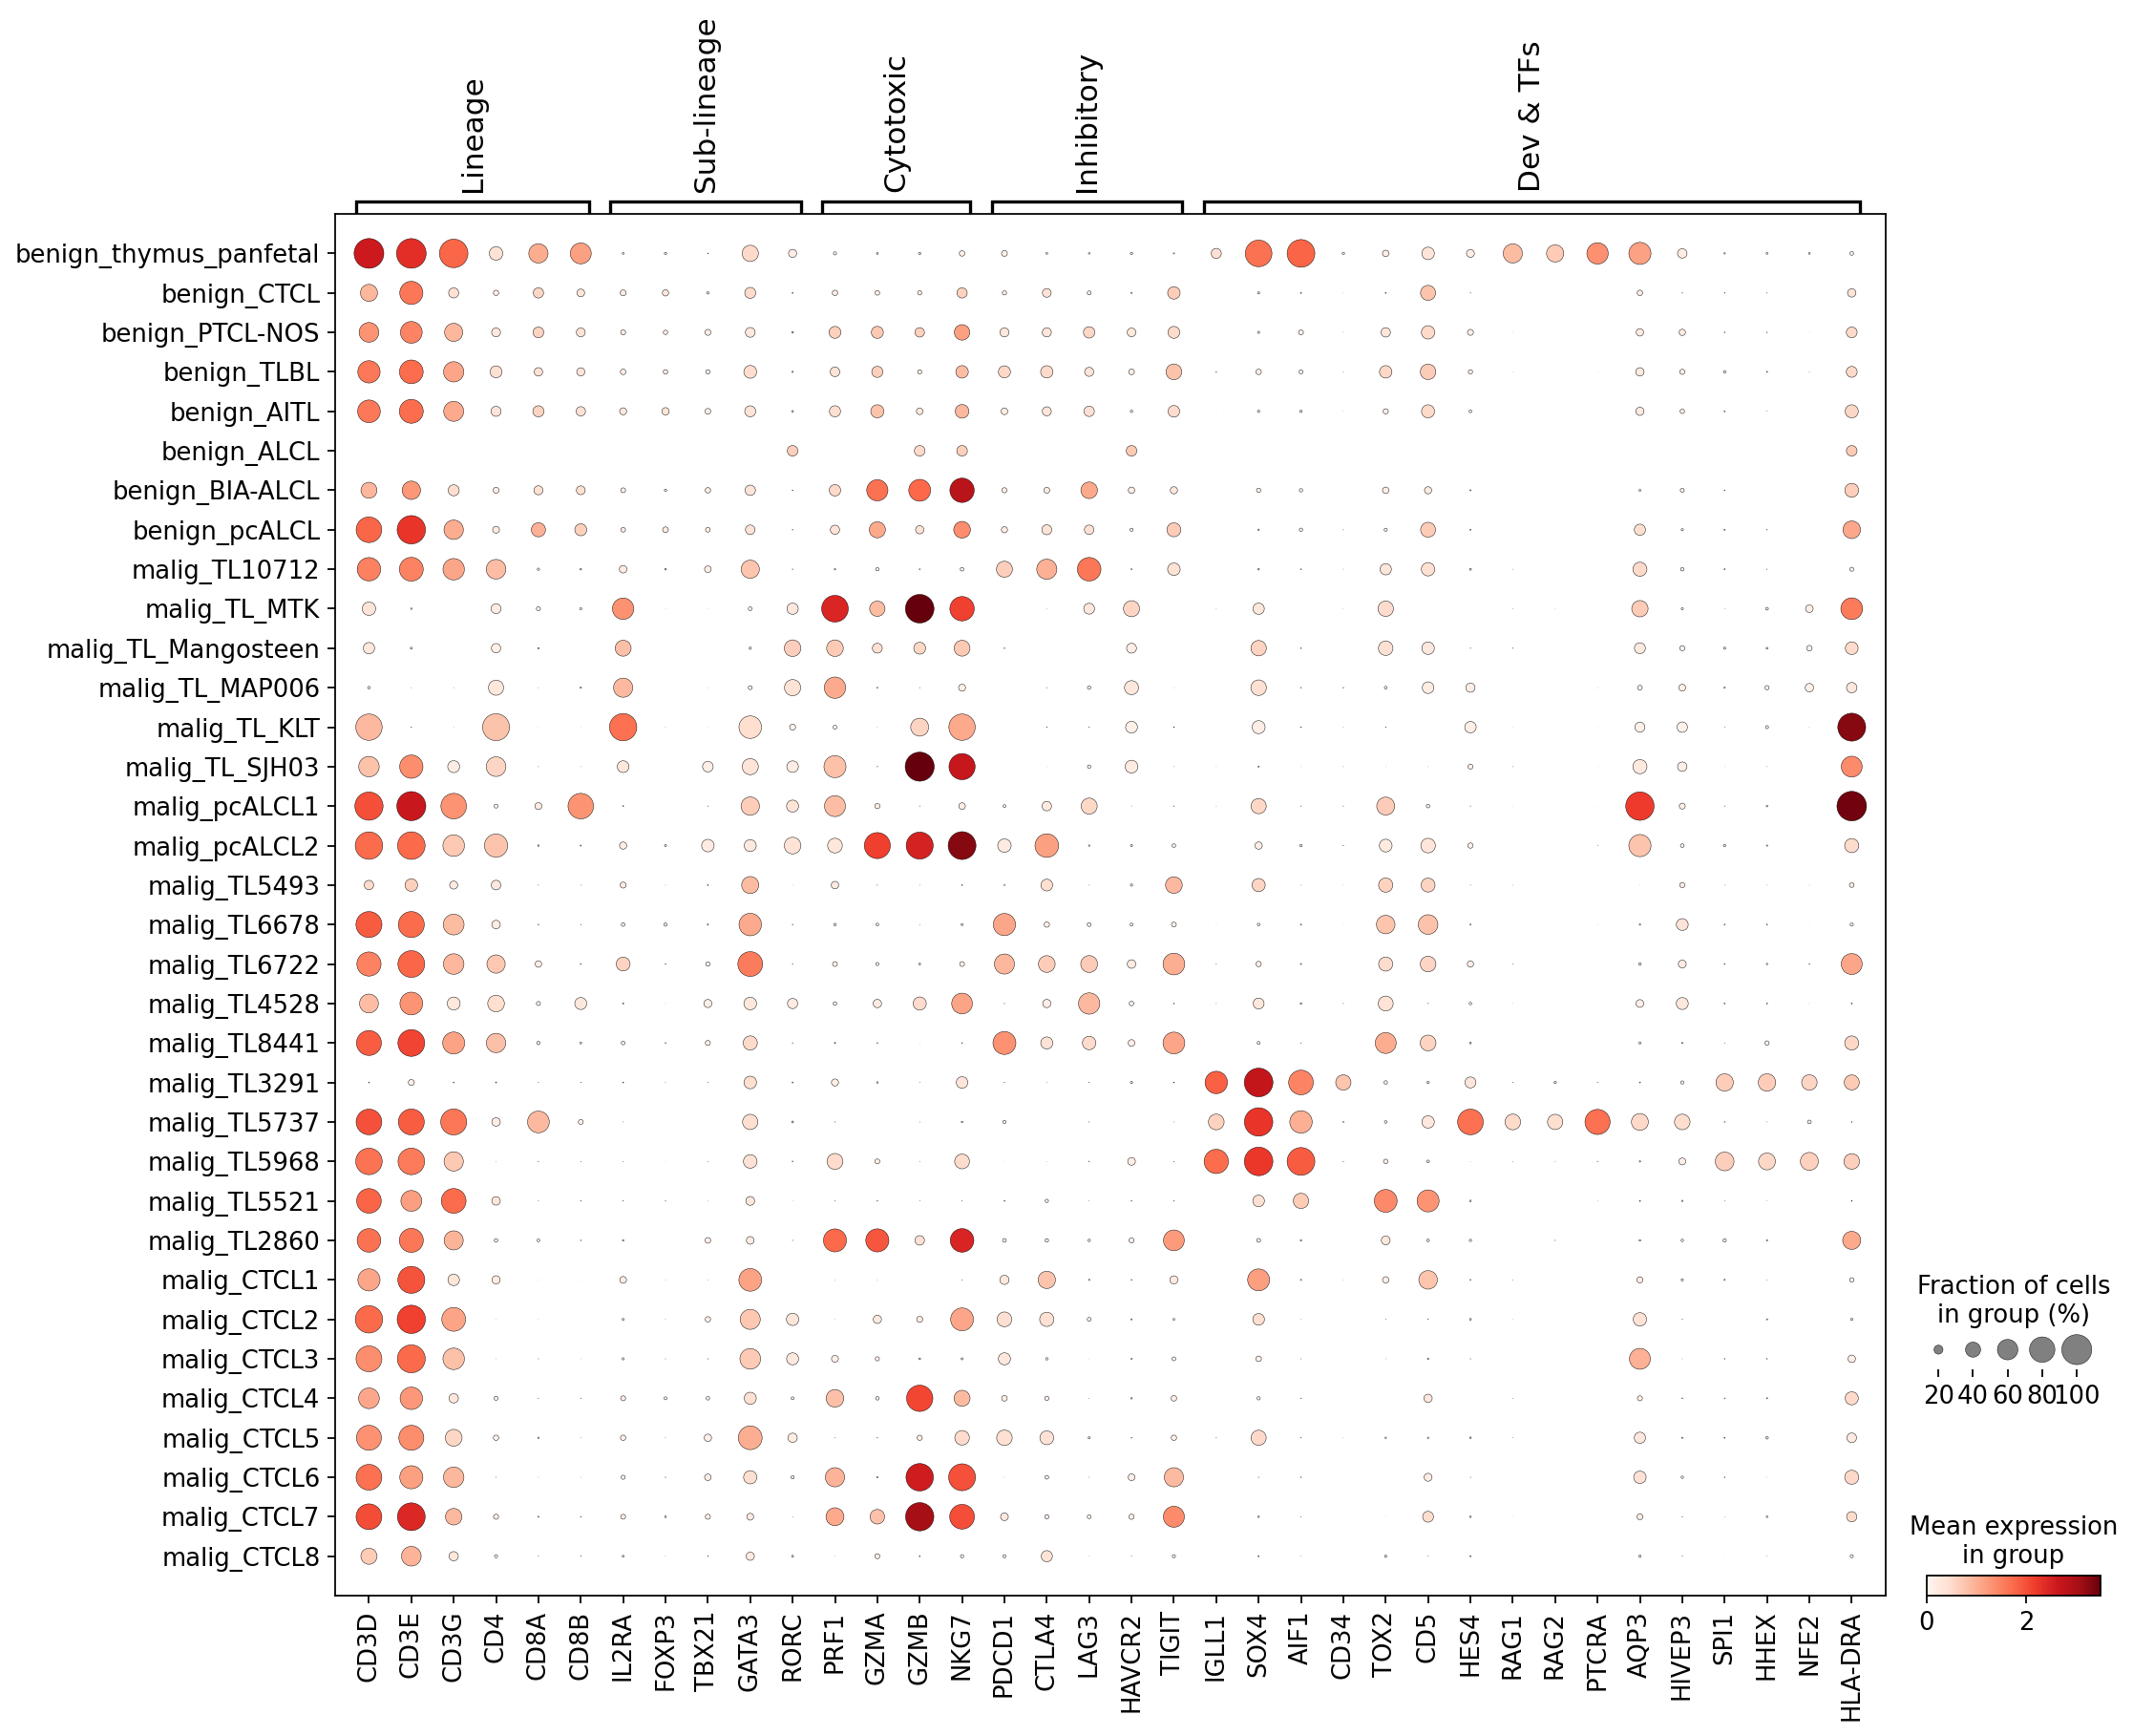

In [57]:
genes = {
    'Lineage': ['CD3D','CD3E','CD3G','CD4','CD8A','CD8B'],
    'Sub-lineage':['IL2RA','FOXP3','TBX21','GATA3','RORC'],
    'Cytotoxic': ['PRF1','GZMA','GZMB','NKG7'],
    'Inhibitory': ['PDCD1','CTLA4','LAG3','HAVCR2','TIGIT'],
    'Dev & TFs': ['IGLL1','SOX4','AIF1','CD34','TOX2','CD5','HES4',
                         'RAG1','RAG2','PTCRA',
                  'AQP3','HIVEP3',
                         'SPI1','HHEX','NFE2']
}

#genes = ['CD3D','CD3E','CD3G','CD4','CD8A','CD8B', 'CD34','IGLL1','CD5','CD7']
sc.settings.set_figure_params(dpi=80)
dp = sc.pl.dotplot(adata, genes, groupby='malignant_call_donor',dendrogram=False, color_map='Reds',
                   categories_order = categories_order)

In [55]:
categories_order = ['benign_thymus_panfetal', 'benign_CTCL', 'benign_PTCL-NOS','benign_TLBL','benign_AITL','benign_ALCL','benign_BIA-ALCL','benign_pcALCL',
                    'malig_TL10712','malig_TL_MTK','malig_TL_Mangosteen','malig_TL_MAP006','malig_TL_KLT','malig_TL_SJH03','malig_pcALCL1','malig_pcALCL2',
                    'malig_TL5493','malig_TL6678','malig_TL6722',
                    'malig_TL4528','malig_TL8441','malig_TL3291','malig_TL5737','malig_TL5968','malig_TL5521','malig_TL2860',
                    'malig_CTCL1','malig_CTCL2','malig_CTCL3','malig_CTCL4','malig_CTCL5','malig_CTCL6','malig_CTCL7','malig_CTCL8']

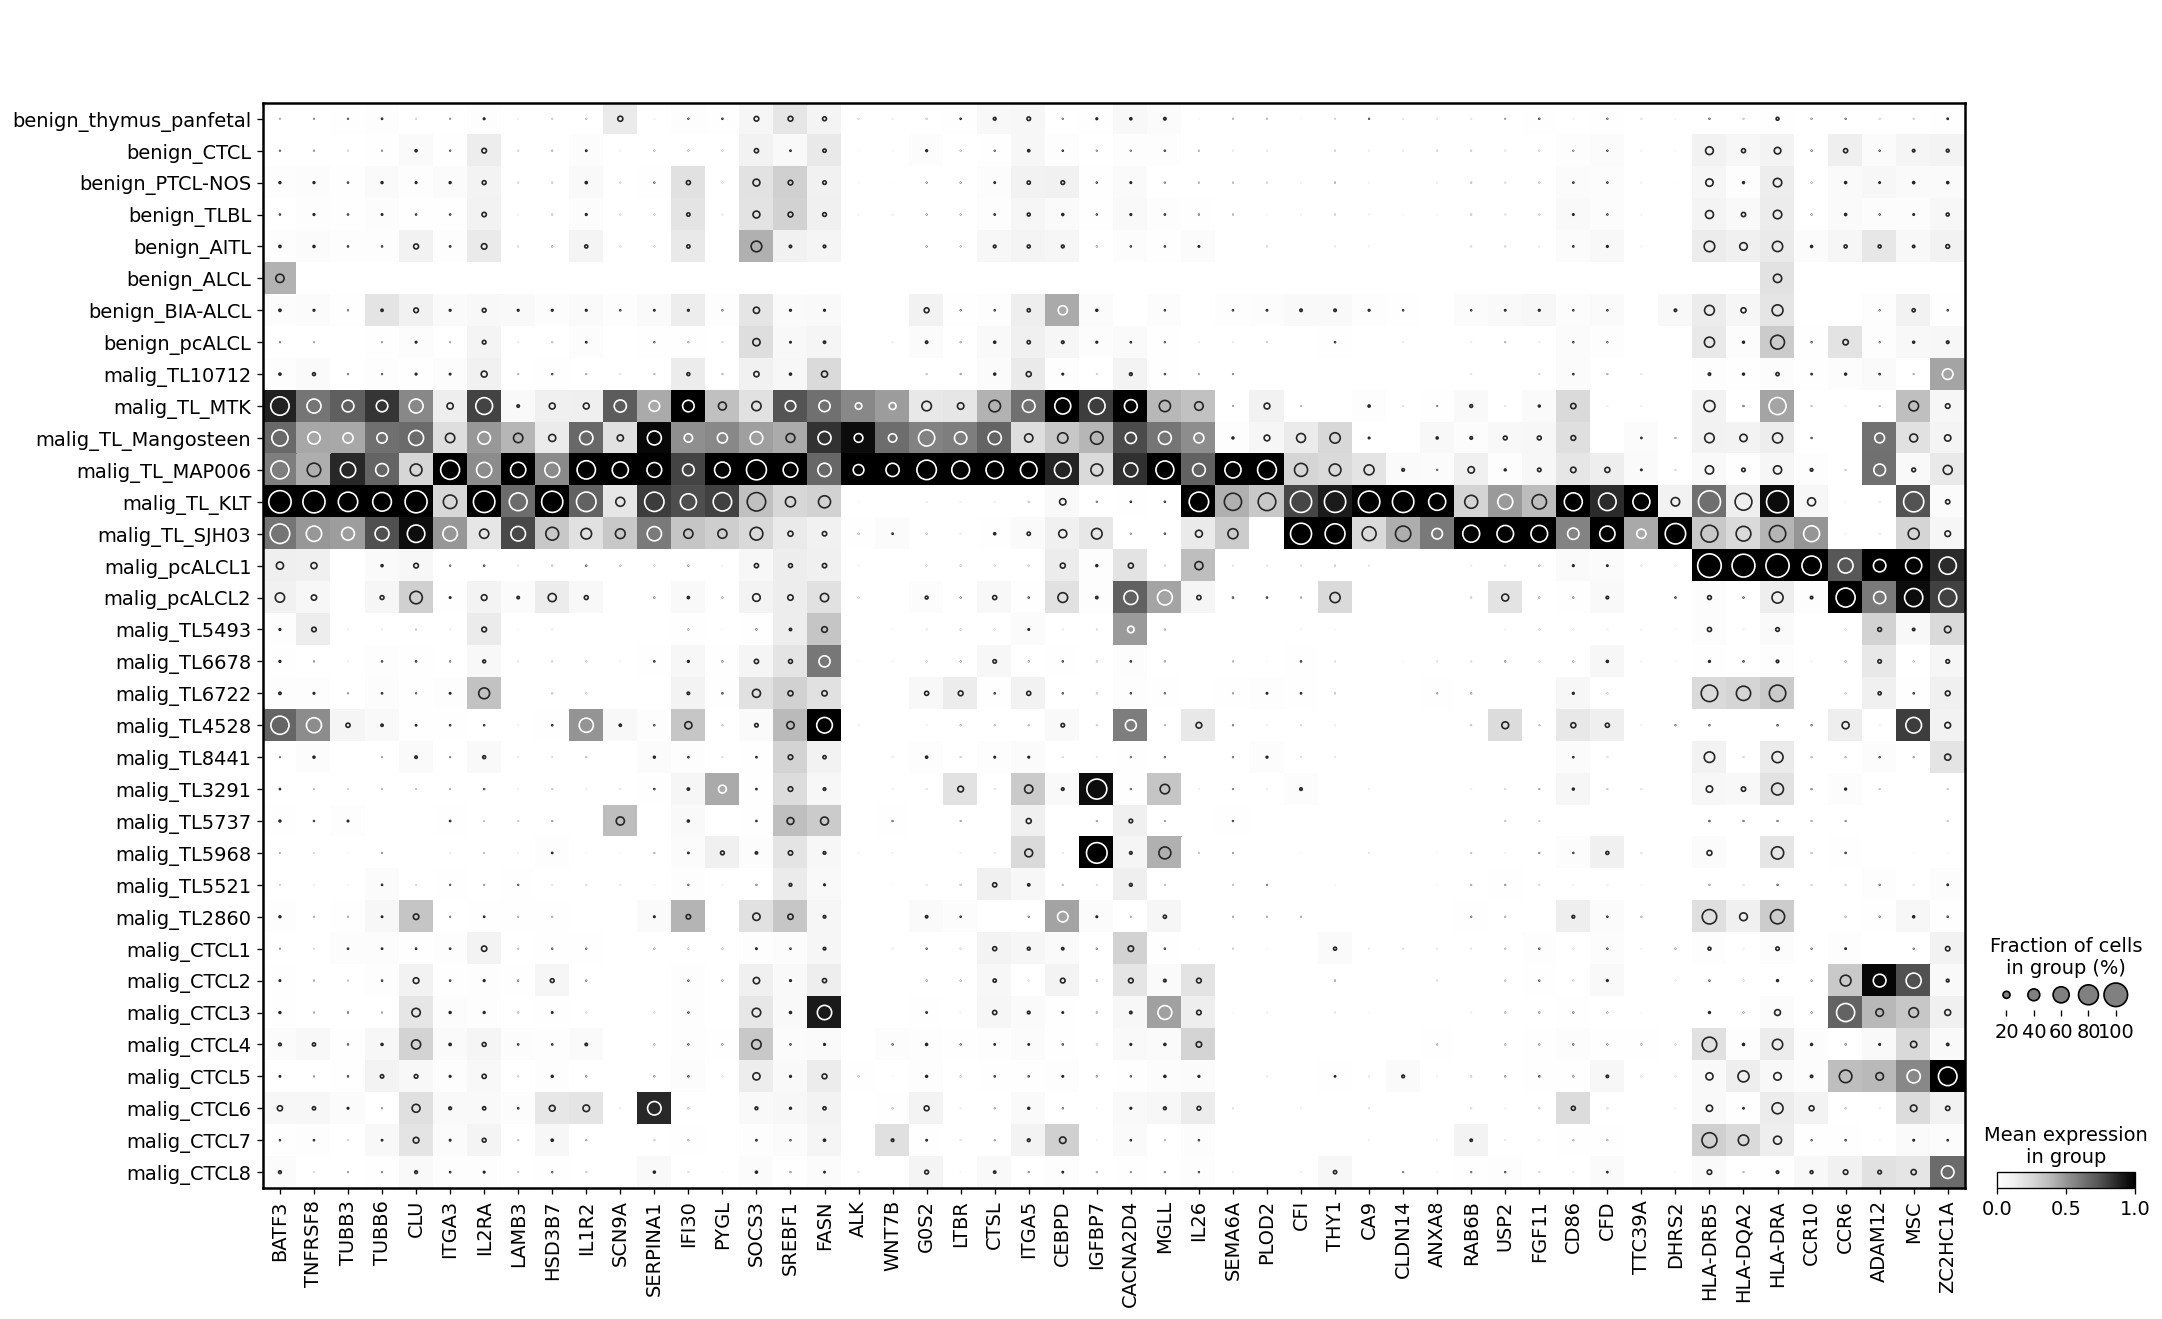

In [97]:

genes = ['BATF3','TNFRSF8','TUBB3','TUBB6','CLU','ITGA3','IL2RA','LAMB3','HSD3B7','IL1R2','SCN9A',
         'SERPINA1','IFI30','PYGL','SOCS3','SREBF1','FASN',
         'ALK','WNT7B','G0S2','LTBR','CTSL','ITGA5','CEBPD','IGFBP7','CACNA2D4','MGLL','IL26','SEMA6A',
         'PLOD2','CFI','THY1','CA9','CLDN14','ANXA8','RAB6B','USP2','FGF11','CD86','CFD','TTC39A','DHRS2',
         'HLA-DRB5','HLA-DQA2','HLA-DRA','CCR10','CCR6','ADAM12','MSC','ZC2HC1A']

dp = sc.pl.dotplot(adata, var_names=genes, groupby='malignant_call_donor',dendrogram=False,
                   var_group_rotation=0, swap_axes=False,standard_scale = 'var',
                   return_fig=True, categories_order = categories_order)
dp.style(cmap='Greys',color_on='square',dot_edge_color=None,dot_edge_lw=1)
dp.savefig('/home/jovyan/farm/T-cell_lym/script/figures/DEGs_ALCL_BIA_pc.pdf')